In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.linear_model import SGDClassifier
import vsm
from lib_classification import *
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 5)
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_colwidth', None) #afficher texte entier dans les colonnes du dataframe
np.set_printoptions(suppress=True) # notation scientifique desactivee

In [14]:
current_folder = PureWindowsPath(globals()['_dh'][0]).as_posix()
path_root = "/".join(current_folder.split("/")[:-2]) #remonter au dossier root du projet
os.chdir(path_root)
path = PureWindowsPath(os.getcwd() + "/data/input/data_philosophy_baptism.parquet")
# path = PureWindowsPath(os.getcwd() + "/data/input/data_middle_age_epistemology.parquet")
path = path.as_posix() #convertir en path linux (convertir les \\ en /)
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = get_balanced_binary_dataset(corpus, class_col_name="category")

print(corpus["category_bin"].value_counts())
print("presence de doublons ?")
print(corpus.id.duplicated().any())
print(corpus.index.duplicated().any())
corpus

0    1833
1    1833
Name: category_bin, dtype: int64
presence de doublons ?
False
False


,id,message,message_preprocessed,category,length,category_bin
0,0,"Polycarpe, disciple de Jean, alors qu’il est exécuté dans ses vieilles années, à environ 86 ans, dit « j’ai été chrétien depuis 86 ans » à son exécuteur. Il a certainement été baptisé très tôt pour pouvoir dire cela. Justin Martyr établit un parallèle entre baptême et circoncision dans son _Dialogue avec le juif Tryphon_. Cyprien et un concile de 36 anciens réunis en Afrique du Nord ont rejeté ceux qui faisaient un parallèle si fort avec la circoncision qu’ils voulaient baptiser le 8èmejour. Ils ont déclaré d’un commun accord que dès la naissance le baptême peut être reçu. Autrement dit, ils étaient tous d’accord qu’il fallait baptiser les enfants et ils voyaient tous un parallèle entre baptême et circoncision. Certains poussaient ce parallèle plus loin que la Parole et ont donc été corrigés par ces évêques.",polycarpe disciple jean alors exécuté vieille année environ an dit « chrétien depuis an » exécuteur a certainement baptisé très tôt pouvoir dire cela justin martyr établit parallèle entre baptême circoncision dialogue juif tryphon cyprien concile ancien réunis afrique nord rejeté ceux faisaient parallèle si fort circoncision voulaient baptiser èmejour déclaré commun accord dès naissance baptême peut être reçu autrement dit tous accord fallait baptiser enfant voyaient tous parallèle entre baptême circoncision certain poussaient parallèle plus loin parole donc corrigé évêque,baptism,819,0
1,1,"Puisque la patristique et la doctrine des sacrements nous intéressent beaucoup, le blog reviendra sur les pères et la régénération baptismale plusieurs fois encore à l’avenir.",puisque patristique doctrine sacrement intéressent beaucoup blog reviendra père régénération baptismale plusieurs foi encore avenir,baptism,175,0
...,...,...,...,...,...,...
3664,3664,"> « Ces genres ont en commun des caractéristiques importantes : une > délimitation claire du sujet étudié ; un vif intérêt pour les définitions ; > un traitement exhaustif des aspects pertinents au moyen d’une structure > thématique ; un usage fréquent des distinctions, en partie pour anticiper un > traitement des différents éléments du sujet, en partie pour résoudre les > difficultés qui sont présentes dans la définition initiale ; des > déclarations explicites, des preuves et arguments qui soutiennent sa > position, et une réfutation correspondante des contre-arguments ». [2]",« genre commun caractéristique importantes délimitation claire sujet étudié vif intérêt définition traitement exhaustif aspect pertinents moyen structure thématique usage fréquent distinction partie anticiper traitement différent élément sujet partie résoudre difficulté présente définition initiale déclaration explicites preuve argument soutiennent position réfutation correspondant contre-arguments »,philosophy,584,1
3665,3665,"La Didaché dit que celui qui va être baptisé doit se préparer par quelques jours de jeûnes. Ainsi, dira-t-on, puisqu’un nourrisson ne peut pas jeûner, les enfants étaient exclus. Ce raisonnement ne tient que si l’on a un présupposé baptiste. Il est en effet possible de lire la Didaché et de penser que seuls les adultes étaient baptisés. J’avoue sans soucis que la Didaché ne mentionne pas de baptêmes d’enfants, mais elle ne les exclut pas non plus. Si je dis, comme l’apôtre Paul, que celui qui ne travaille pas ne doit pas manger non plus, cela ne veut pas dire qu’il ne faut pas donner à manger aux nourrissons sous prétexte qu’ils ne travaillent pas ! Le bon sens nous guide ici. De la même manière, il est possible que les chrétiens qui ont écrit la Didaché soient en faveur du baptême des enfants, tout en disant que celui qui se fait baptiser doit jeûner, les nourrissons étant dispensés du jeûne par le bon sens. Par ailleurs, je rappelle que les réformés aussi placent des conditions (que nous pensons instituées par Dieu) différentes quand il s’agit de baptiser un adulte ou un enfant. Un adulte doit confesser la foi, un

In [4]:
X = corpus["message_preprocessed"]
y = corpus["category"]
# y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)
# X_train = X_train.iloc[0:500]

In [4]:
count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)

X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

hashing_vectorizer = HashingVectorizer()
X_train_hashing = hashing_vectorizer.fit_transform(X_train)

X_train_observed_expected = vsm.observed_over_expected(X_train_count).round(2)
# X_train_observed_expected = np.ravel(X_train_observed_expected)
# X_train_observed_expected = np.delete(X_train_observed_expected, np.where(X_train_observed_expected == 0))

X_train_pmi = vsm.pmi(X_train_count)

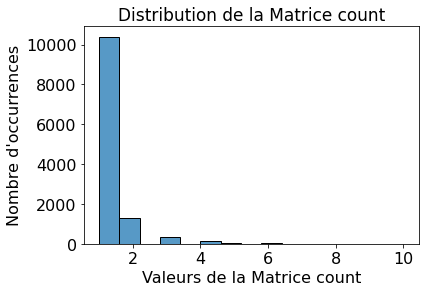

In [5]:
# Distribution des valeurs de la matrice count
path = PureWindowsPath(os.getcwd() + "\\data\\output\\count_matrix_distribution.png")
path = path.as_posix()

sb.histplot(X_train_count.data)
plt.xlabel("Valeurs de la Matrice count", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la Matrice count", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.savefig(path)
plt.show()

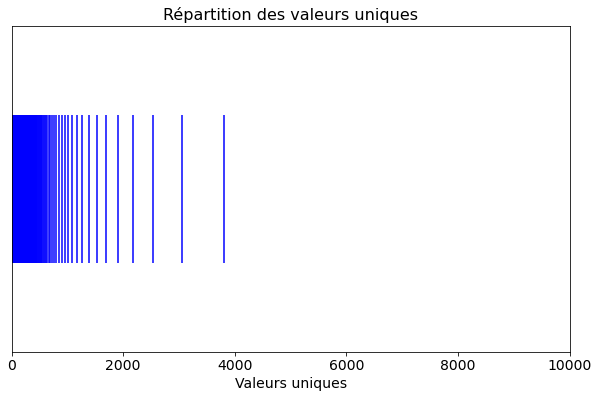

In [6]:
# Graphique avec barres en 1D des valeurs uniques (pour voir comment elles sont reparties, que a droite ?, que a gauche ?, etc.)
# sb.scatterplot(x=X_tfidf_unique, y=np.zeros_like(X_tfidf_unique), sizes=(10000,10000))
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_unique_distribution.png")
path = path.as_posix()

plt.figure()
plt.hlines(0,0,1)  # Draw a horizontal line
plt.eventplot(np.unique(X_train_observed_expected), orientation='horizontal', colors='b')
plt.xlabel("Valeurs uniques", size=14)
plt.title("Répartition des valeurs uniques", size=16)
plt.xticks(fontsize=14)
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.rcParams["figure.figsize"] = (9, 4)
plt.xlim(0, 10000)
plt.savefig(path)
plt.show()

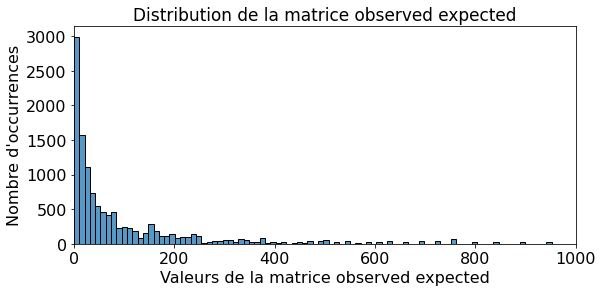

In [7]:
# Distribution des valeurs de la matrice observed expected
path = PureWindowsPath(os.getcwd() + "\\data\\output\\observed_expected_matrix_distribution.png")
path = path.as_posix()

sb.histplot(np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), edgecolor="black", linewidth=1)
plt.xlabel("Valeurs de la matrice observed expected", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution de la matrice observed expected", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 1000)
plt.savefig(path)
plt.show()

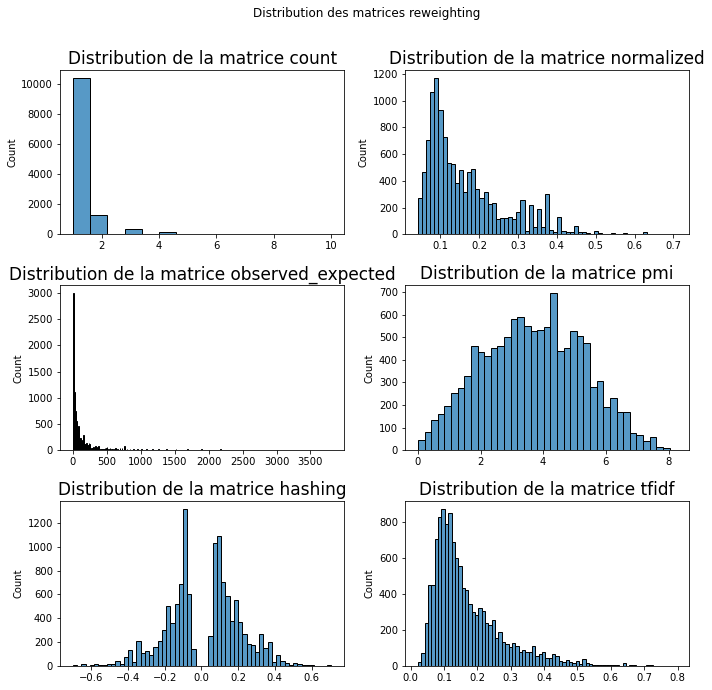

In [8]:
# Plot de toutes les distributions de matrices cote a cote
# Count, normalisation L2, expected observed, pmi, hashing, tfidf = 5 graphiques
path = PureWindowsPath(os.getcwd() + "\\data\\output\\count_matrix_reweighting_distribution.png")
path = path.as_posix()

fig, axes = plt.subplots(3, 2, figsize = (10, 10)) # Create a figure for 2 subplots (1 row, 2 columns)
fig.suptitle('Distribution des matrices reweighting')
fig.tight_layout(pad=3.0) #espace entre les graphiques

sb.histplot(X_train_count.data, edgecolor="black", linewidth=1, ax=axes[0,0])
axes[0,0].set_title("Distribution de la matrice count", size=17)

sb.histplot(X_train_normalized.data, edgecolor="black", linewidth=1, ax=axes[0,1])
axes[0,1].set_title("Distribution de la matrice normalized", size=17)

sb.histplot(np.ravel(X_train_observed_expected[X_train_observed_expected != 0]), edgecolor="black", linewidth=1, ax=axes[1,0])
axes[1,0].set_title("Distribution de la matrice observed_expected", size=17)

sb.histplot(np.ravel(X_train_pmi[X_train_pmi != 0]), edgecolor="black", linewidth=1, ax=axes[1,1])
axes[1,1].set_title("Distribution de la matrice pmi", size=17)

sb.histplot(X_train_hashing.data, edgecolor="black", linewidth=1, ax=axes[2,0])
axes[2,0].set_title("Distribution de la matrice hashing", size=17)

sb.histplot(X_train_tfidf.data, edgecolor="black", linewidth=1, ax=axes[2,1])
axes[2,1].set_title("Distribution de la matrice tfidf", size=17)

plt.savefig(path)

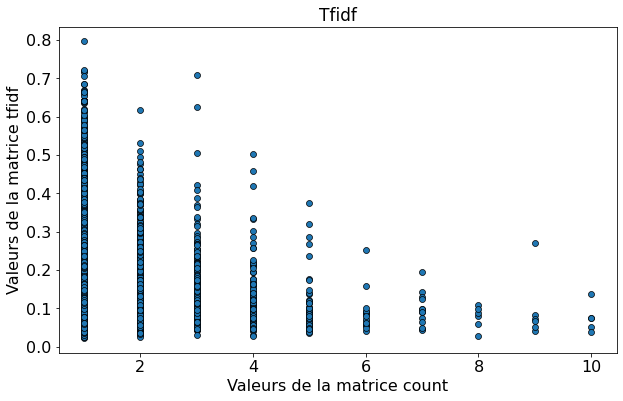

In [9]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice tfidf
path = PureWindowsPath(os.getcwd() + "\\data\\output\\tfidf_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_tfidf.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice tfidf", size=16)
plt.title("Tfidf", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

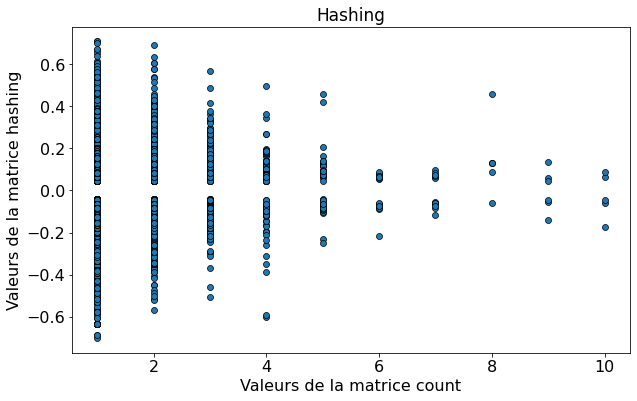

In [10]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice hashing
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=X_train_count.data, y=X_train_hashing.data, edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice hashing", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

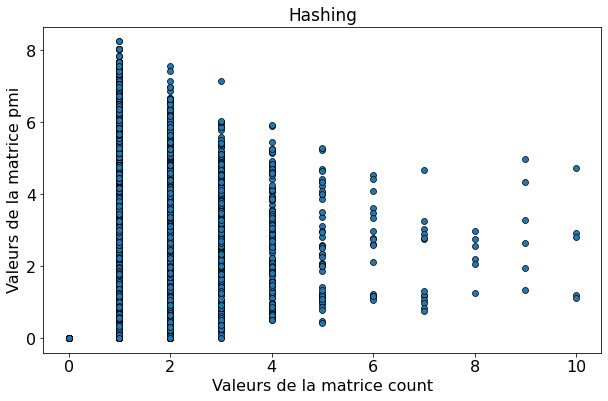

In [11]:
# Distribution matrice matrice
# Distribution des valeurs de la matrice pmi
path = PureWindowsPath(os.getcwd() + "\\data\\output\\hashing_vs_count_distribution.png")
path = path.as_posix()

sb.scatterplot(x=np.ravel(X_train_count.toarray()), y=np.ravel(X_train_pmi), edgecolor="black", linewidth=0.7)
plt.xlabel("Valeurs de la matrice count", size=16)
plt.ylabel("Valeurs de la matrice pmi", size=16)
plt.title("Hashing", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
# plt.xlim(0, 0.6)
plt.savefig(path)
plt.show()

Tests de performances sur plusieurs transformations de matrices (reweighting)

In [7]:
y

0        middle_age
1      epistemology
           ...     
712    epistemology
713    epistemology
Name: category, Length: 714, dtype: object

In [26]:
X_train_tfidf_svd.shape

(2456, 50)

(-0.2, 0.2)

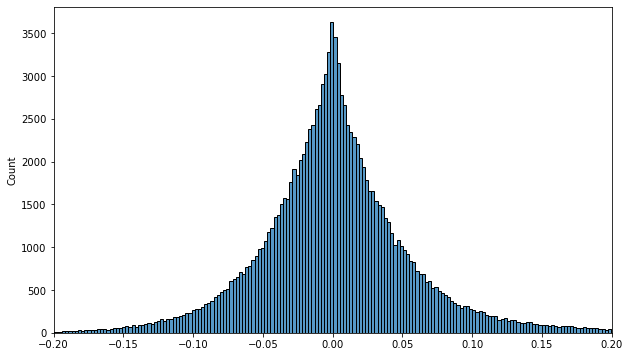

In [30]:
# Reduction de dimension truncated svd/lsa apres tfidf 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf_svd = svd.fit_transform(X_train_tfidf)
X_train_tfidf_svd
plt.rcParams["figure.figsize"] = (10, 6)
sb.histplot(np.ravel(X_train_tfidf_svd[X_train_tfidf_svd != 0]), edgecolor="black", linewidth=1)
plt.xlim(-0.2, 0.2)

In [31]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

pourcentage variance expliquee par toutes les variables svd = 18.202692088512283
pourcentage variance expliquee par les 40 premieres variables svd = 15.956815568276278


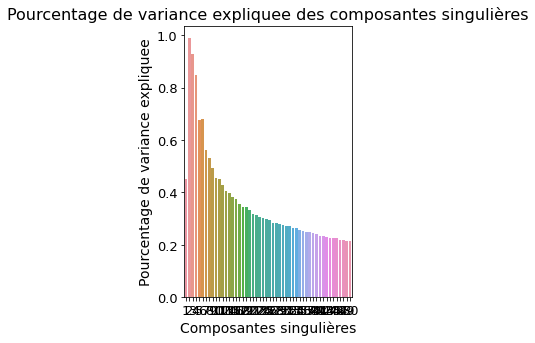

In [23]:
n_dim_chosen = 50
df_explained_var = pd.DataFrame(list(zip(range(1, n_dim_chosen + 1), svd.explained_variance_ratio_[:n_dim_chosen] * 100)))
print("pourcentage variance expliquee par toutes les variables svd =", sum(svd.explained_variance_ratio_ * 100))
print("pourcentage variance expliquee par les 40 premieres variables svd =", sum(svd.explained_variance_ratio_[:40] * 100))
sb.barplot(data=df_explained_var, x=0, y=1)
plt.xlabel("Composantes singulières", size=14)
plt.ylabel("Pourcentage de variance expliquee", size=14)
plt.title("Pourcentage de variance expliquee des composantes singulières", size=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.rcParams["figure.figsize"] = (3, 5)

In [32]:
# Methode 1 : automatique (cross validation de sklearn)
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning) #pour ignorer les warnings de type "deprecated"

X = corpus["message_preprocessed"]
# y = corpus["category"]
y = corpus["category_bin"]
indices = corpus["id"]
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(X_train)
X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
hashing_vectorizer = HashingVectorizer()
X_train_hashing = hashing_vectorizer.fit_transform(X_train)
X_train_observed_expected = vsm.observed_over_expected(X_train_count)
X_train_pmi = vsm.pmi(X_train_count)

X_test_count = count_vectorizer.transform(X_test)
X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_hashing = hashing_vectorizer.transform(X_test)
X_test_tfidf_svd = svd.transform(X_test_tfidf)
X_test_observed_expected = vsm.observed_over_expected(X_test_count)
X_test_pmi = vsm.pmi(X_test_count)

transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi", "tfidf + lsa"]
matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
                        X_train_observed_expected, X_train_pmi, X_train_tfidf_svd]
matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
                    X_test_observed_expected, X_test_pmi, X_test_tfidf_svd]

scoring = ['f1_macro', 'recall']
num_iter = 5
for i_matrix in range(len(transformations_names)):
    model = SGDClassifier()
    matrix_train = matrices_train[i_matrix]
    matrix_name = transformations_names[i_matrix]

    kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=num_iter, random_state=None)
    cv_results = cross_validate(model, matrix_train, y_train, cv=kfold, scoring=scoring)
    for k, scores in cv_results.items():
        cv_results[k] = round(np.mean(scores), 4) #on fait la moyenne de chaque score (rappel, precision, etc.) pour les k experiences
    print((str(list(cv_results.items())[2:])+" ({0})").format(matrix_name)) #2: pour ignorer les info inutiles

c:\Users\eupho\anaconda3\lib\site-packages\scipy\sparse\base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


[('test_f1_macro', 0.9356), ('test_recall', 0.9455)] (count)
[('test_f1_macro', 0.945), ('test_recall', 0.9513)] (normalized)
[('test_f1_macro', 0.9519), ('test_recall', 0.9575)] (tfidf)
[('test_f1_macro', 0.9467), ('test_recall', 0.9526)] (hashing)
[('test_f1_macro', 0.8107), ('test_recall', 0.8132)] (observed_expected)
[('test_f1_macro', 0.9271), ('test_recall', 0.9381)] (pmi)
[('test_f1_macro', 0.9195), ('test_recall', 0.9224)] (tfidf + lsa)


In [ ]:
# Resultats et des tests
# Pour datasets moyens (4000 exemples)

[('test_f1_macro', 0.9263), ('test_recall', 0.9252)] (count)
[('test_f1_macro', 0.943), ('test_recall', 0.9006)] (normalized)
[('test_f1_macro', 0.9473), ('test_recall', 0.905)] (tfidf)
[('test_f1_macro', 0.9423), ('test_recall', 0.8997)] (hashing)
[('test_f1_macro', 0.8436), ('test_recall', 0.8485)] (observed_expected)
[('test_f1_macro', 0.9258), ('test_recall', 0.9061)] (pmi)


In [25]:
# Methode 2 : manuelle (split train test classique)
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier
np.seterr(invalid="ignore")

transformations_names = ["count", "normalized", "tfidf", "hashing", "observed_expected", "pmi"]
scores = [0, 0, 0, 0, 0, 0]
num_iter = 60

In [26]:
np.seterr(invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [27]:
for iter in range(num_iter):
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.33, random_state=42)

    count_vectorizer = CountVectorizer()
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_train_normalized = normalize(X_train_count, norm='l2', axis=1) #normalisation par ligne
    tfidf_vectorizer = TfidfVectorizer()
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    hashing_vectorizer = HashingVectorizer()
    X_train_hashing = hashing_vectorizer.fit_transform(X_train)
    X_train_observed_expected = vsm.observed_over_expected(X_train_count)
    X_train_pmi = vsm.pmi(X_train_count)

    X_test_count = count_vectorizer.transform(X_test)
    X_test_normalized = normalize(X_test_count, norm='l2', axis=1) #normalisation par ligne
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    X_test_hashing = hashing_vectorizer.transform(X_test)
    X_test_observed_expected = vsm.observed_over_expected(X_test_count)
    X_test_pmi = vsm.pmi(X_test_count)

    matrices_train = [X_train_count, X_train_normalized, X_train_tfidf, X_train_hashing, 
                        X_train_observed_expected, X_train_pmi]
    matrices_test = [X_test_count, X_test_normalized, X_test_tfidf, X_test_hashing, 
                        X_test_observed_expected, X_test_pmi]

    for i_matrix in range(len(transformations_names)):   
        model = SGDClassifier()
        matrix_train = matrices_train[i_matrix]
        matrix_test = matrices_test[i_matrix]
        model.fit(matrix_train, y_train)
        y_pred = model.predict(matrix_test)
        scores[i_matrix] += f1_score(y_test, y_pred, average='macro')

c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
c:\Users\eupho\anaconda3\lib\site-

In [28]:
for i_matrix in range(len(transformations_names)):   
    print("test_f1_macro, {} ({})".format(scores[i_matrix] / num_iter, transformations_names[i_matrix]))

test_f1_macro, 0.9300525610353334 (count)
test_f1_macro, 0.9611005737280665 (normalized)
test_f1_macro, 0.9598424614374622 (tfidf)
test_f1_macro, 0.9588659915562114 (hashing)
test_f1_macro, 0.8452439315426188 (observed_expected)
test_f1_macro, 0.9302564354624099 (pmi)
